In [1]:
import json
import requests
import pandas as pd
from tqdm import tqdm
import sqlite3
import datetime


# functions
def get_option_name_and_settlement(coin):
    """
    :param coin: crypto-currency coin name ('BTC', 'ETH')
    :return: 2 lists:
                        1.  list of traded options for the selected coin;
                        2.  list of settlement period for the selected coin.
    """

    # requests public API
    r = requests.get("https://test.deribit.com/api/v2/public/get_instruments?currency=" + coin + "&kind=option")
    result = json.loads(r.text)

    # get option name
    name = pd.json_normalize(result['result'])['instrument_name']
    name = list(name)

    # get option settlement period
    settlement_period = pd.json_normalize(result['result'])['settlement_period']
    settlement_period = list(settlement_period)

    return name, settlement_period


def get_option_data(coin):
    """
    :param coin: crypto-currency coin name ('BTC', 'ETH')
    :return: pandas data frame with all option data for a given coin
    """

    # get option name and settlement
    coin_name = get_option_name_and_settlement(coin)[0]
    settlement_period = get_option_name_and_settlement(coin)[1]

    # initialize data frame
    coin_df = []

    # initialize progress bar
    pbar = tqdm(total=len(coin_name))

    # loop to download data for each Option Name
    for i in range(len(coin_name)):
        # download option data -- requests and convert json to pandas
        r = requests.get('https://test.deribit.com/api/v2/public/get_order_book?instrument_name=' + coin_name[i])
        result = json.loads(r.text)
        df = pd.json_normalize(result['result'])

        # add settlement period
        df['settlement_period'] = settlement_period[i]

        # append data to data frame
        coin_df.append(df)

        # update progress bar
        pbar.update(1)

    # finalize data frame
    coin_df = pd.concat(coin_df)

    # remove useless columns from coin_df
    columns = ['state', 'estimated_delivery_price']
    coin_df.drop(columns, inplace=True, axis=1)

    # close the progress bar
    pbar.close()

    return coin_df

In [2]:
import certifi

# Get a list of all active options from the Deribit API.
def get_all_active_options(coin):
    """

    :param coin: 'BTC' or 'ETH'
    :return: list of all active options from the Deribit API
    """

    # import modules
    import urllib.request
    import json
    import pandas as pd

    # url connection
    url = "https://test.deribit.com/api/v2/public/get_instruments?currency=BTC&kind=option&expired=false"
    with urllib.request.urlopen(url, cafile=certifi.where()) as url:
        data = json.loads(url.read().decode())
    data = pd.DataFrame(data['result']).set_index('instrument_name')
    data['creation_date'] = pd.to_datetime(data['creation_timestamp'], unit='ms')
    data['expiration_date'] = pd.to_datetime(data['expiration_timestamp'], unit='ms')

    print(f'{data.shape[0]} active options')

    return data

def filter_options(price, active_options):
    """

    :param price: current coin price
    :param active_options: list of active options
    :return: list of active options after filtration
    """

    # import modules
    import pandas as pd

    # Get Put/Call information
    pc = active_options.index.str.strip().str[-1]

    # Set "moneyness"
    active_options['m'] = active_options['strike'] / price
    active_options.loc[pc == 'P', 'm'] = -active_options['m']

    # Set days until expiration
    active_options['t'] = (active_options['expiration_date'] - pd.Timestamp.today()).dt.days

    return active_options

# Get Tick data for a given instrument from the Deribit API
def get_tick_data(instrument_name):

    # import modules
    import urllib.request
    import json
    import pandas as pd

    # url connection
    url = f"https://test.deribit.com/api/v2/public/ticker?instrument_name={instrument_name}"
    with urllib.request.urlopen(url, cafile=certifi.where()) as url:
        data = json.loads(url.read().decode())

    # convert json to pandas.DataFrame
    data = pd.json_normalize(data['result'])
    data.index = [instrument_name]

    return data


# Loop through all filtered options to get the current 'ticker' data
def get_all_option_data(coin):

    # get tick data Perpetual
    option_data = get_tick_data(coin + '-PERPETUAL')

    # get active options
    options = filter_options(price=option_data['last_price'][0], active_options=get_all_active_options(coin=coin))
    for o in options.index:
        option_data = option_data.append(get_tick_data(o))

    return option_data

# data pre-processing
def data_preprocessing(coin):
    """

    :param coin: 'BTC' or 'ETH'
    :return: pandas.DataFrame with relevant financial data
    """

    # import modules
    import pandas as pd
    import numpy as np

    # disable false positive warning, default='None'
    pd.options.mode.chained_assignment = None

    # get data
    print('Get ' + coin + ' options data')
    df = get_all_option_data(coin=coin)

    # add additional metrics to data
    df['t'] = np.nan
    df['strike'] = np.nan
    df['expiration'] = np.nan

    # indexing index
    index = df[1:].index.map(lambda x: x.split('-'))

    # calculate days until expiration
    days = [element[1] for element in index]
    maturity = days
    days = (pd.to_datetime(days) - pd.Timestamp.today()).days

    # add days to expiration
    df.t[1:] = np.array(days)

    # Pull strike from instrument name
    strike = [int(element[2]) for element in index]

    # add strike
    df.strike[1:] = strike

    # calculate moneyness
    df['m'] = df['strike'] / df['last_price'][0]

    # pull maturity
    maturity = pd.to_datetime(maturity) + pd.DateOffset(hours=10)
    maturity = maturity.astype('int64')
    df.expiration[1:] = maturity

    # consider only t>0
    df = df.query('t>0')

    print('additional metrics added')
    print('----------------------------------------------------------------------')

    return df

In [3]:
#  volatility smile plot
def iv_smile(coin_df, time_to_maturity):

    coin='BTC'

    # subset df
    call_df = coin_df[coin_df['instrument_name'].str.contains('-C')]

    # pull days to maturity
    days_to_maturity = list(call_df['t'].unique())
    maturity = min(days_to_maturity, key=lambda x: abs(x-time_to_maturity))

    # subset df for the maturity
    df = call_df[call_df['t'] == maturity].sort_values('m')

    return df

In [5]:
btc_df = data_preprocessing(coin='BTC')

Get BTC options data


<ipython-input-2-cc27600d8ac8>:61: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  with urllib.request.urlopen(url, cafile=certifi.where()) as url:
<ipython-input-2-cc27600d8ac8>:18: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  with urllib.request.urlopen(url, cafile=certifi.where()) as url:


216 active options
additional metrics added
----------------------------------------------------------------------


In [6]:
btc_7004=pd.read_csv(f'C:/Users/mbaud/Desktop/alternative finance/data deredit/derebit_data_07_04_2022.csv', sep=';')
btc_7004

,Unnamed: 0,timestamp,state,settlement_price,open_interest,min_price,max_price,mark_price,last_price,instrument_name,...,ask_iv,greeks.vega,greeks.theta,greeks.rho,greeks.gamma,greeks.delta,t,strike,expiration,m
0,BTC-24JUN22-30000-C,1649346087182,open,0.351526,180.7,0.0001,0.8505,0.350857,0.3395,BTC-24JUN22-30000-C,...,79.05,44.53159,-26.82109,47.50194,0.00001,0.86157,77.0,30000.0,1.656065e+18,0.693273
1,BTC-22APR22-35000-P,1649346087182,open,0.002944,516.4,0.0001,0.5025,0.002764,0.0010,BTC-22APR22-35000-P,...,0.00,8.62238,-19.46094,-0.87848,0.00002,-0.04768,14.0,35000.0,1.650622e+18,0.808818
2,BTC-24JUN22-55000-C,1649346087182,open,0.041406,424.8,0.0001,0.5695,0.069865,0.0250,BTC-24JUN22-55000-C,...,0.00,73.66146,-38.84026,24.88947,0.00002,0.33746,77.0,55000.0,1.656065e+18,1.271000
3,BTC-30SEP22-50000-C,1649346087182,open,0.170562,664.3,0.0001,0.6670,0.167498,0.1630,BTC-30SEP22-50000-C,...,78.72,123.09316,-27.00748,75.61582,0.00002,0.52028,175.0,50000.0,1.664532e+18,1.155455
4,BTC-24JUN22-25000-C,1649346087182,open,0.443990,132.5,0.0001,0.9460,0.446216,0.4465,BTC-24JUN22-25000-C,...,99.58,28.11468,-17.94127,44.66783,0.00001,0.92646,77.0,25000.0,1.656065e+18,0.577727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,BTC-30DEC22-55000-C,1649346104302,open,0.157404,232.2,0.0001,0.6580,0.158037,0.1575,BTC-30DEC22-55000-C,...,68.13,153.78217,-19.56147,106.21272,0.00002,0.47998,266.0,55000.0,1.672394e+18,1.271000
198,BTC-30DEC22-20000-C,1649346104303,open,0.580155,146.7,0.0780,1.0775,0.577970,0.4760,BTC-30DEC22-20000-C,...,104.84,44.27091,-6.30471,120.36715,0.00000,0.94282,266.0,20000.0,1.672394e+18,0.462182
199,BTC-31MAR23-45000-P,1649346104301,open,0.235834,300.1,0.0001,0.7650,0.265175,0.2340,BTC-31MAR23-45000-P,...,63.08,168.39633,-16.83002,-277.20550,0.00001,-0.35214,357.0,45000.0,1.680257e+18,1.039909
200,BTC-9APR22-45000-C,1649346104301,open,NaN,1.0,0.0001,0.5055,0.005853,0.0005,BTC-9APR22-45000-C,...,0.00,8.63080,-182.75747,0.42101,0.00014,0.21727,1.0,45000.0,1.649498e+18,1.039909


In [83]:
test_10=iv_smile(btc_7004,10)
test_10

,Unnamed: 0,timestamp,state,settlement_price,open_interest,min_price,max_price,mark_price,last_price,instrument_name,...,ask_iv,greeks.vega,greeks.theta,greeks.rho,greeks.gamma,greeks.delta,t,strike,expiration,m
82,BTC-15APR22-35000-C,1649346094230,open,0.196062,102.0,0.0001,0.6925,0.192679,0.1964,BTC-15APR22-35000-C,...,395.07,4.22724,-22.03687,7.08120,0.00001,0.97037,7.0,35000.0,1.650017e+18,0.808818
174,BTC-15APR22-40000-C,1649346102288,open,0.087207,86.0,0.0001,0.5825,0.082900,0.0871,BTC-15APR22-40000-C,...,149.80,15.22443,-56.28589,6.90069,0.00007,0.84079,7.0,40000.0,1.650017e+18,0.924364
108,BTC-15APR22-42000-C,1649346096245,open,0.053433,175.2,0.0001,0.5490,0.049286,0.0537,BTC-15APR22-42000-C,...,59.99,23.06463,-85.27166,5.53893,0.00010,0.65757,7.0,42000.0,1.650017e+18,0.970582
115,BTC-15APR22-44000-C,1649346097252,open,0.022753,303.0,0.0001,0.5220,0.022475,0.5275,BTC-15APR22-44000-C,...,0.00,24.62237,-82.67688,3.68336,0.00012,0.42701,7.0,44000.0,1.650017e+18,1.016800
81,BTC-15APR22-45000-C,1649346094230,open,0.017180,104.3,0.0001,0.5165,0.016639,0.0005,BTC-15APR22-45000-C,...,0.00,22.69267,-82.03458,2.83976,0.00010,0.32852,7.0,45000.0,1.650017e+18,1.039909
180,BTC-15APR22-46000-C,1649346103297,open,0.011732,120.5,0.0001,0.5105,0.010749,0.0005,BTC-15APR22-46000-C,...,103.88,19.36962,-70.02169,2.05772,0.00009,0.23674,7.0,46000.0,1.650017e+18,1.063019
158,BTC-15APR22-48000-C,1649346101282,open,0.005519,79.9,0.0001,0.5055,0.005585,0.0055,BTC-15APR22-48000-C,...,60.84,13.32275,-53.03375,1.13835,0.00006,0.13061,7.0,48000.0,1.650017e+18,1.109237
147,BTC-15APR22-50000-C,1649346100273,open,0.003052,169.8,0.0001,0.5035,0.003905,0.0105,BTC-15APR22-50000-C,...,60.72,9.90277,-45.42981,0.75265,0.00004,0.08657,7.0,50000.0,1.650017e+18,1.155455
132,BTC-15APR22-55000-C,1649346098260,open,0.001287,52.4,0.0001,0.5015,0.001695,0.5010,BTC-15APR22-55000-C,...,0.00,4.84730,-27.80969,0.30303,0.00001,0.03498,7.0,55000.0,1.650017e+18,1.271000
189,BTC-15APR22-60000-C,1649346103295,open,0.001210,34.1,0.0001,0.5010,0.001316,0.5010,BTC-15APR22-60000-C,...,0.00,3.47373,-24.64779,0.20131,0.00001,0.02342,7.0,60000.0,1.650017e+18,1.386546


In [84]:
import pysabr
import numpy as np  
from pysabr import Hagan2002LognormalSABR as LNsabr 
from pysabr import hagan_2002_lognormal_sabr as hagan2002LN

strikes = test_10.strike
LogNormalVols = test_10.mark_iv

spot = 43503.85

beta = 0.5 
calibration_LN = LNsabr(f = spot, shift = 0, t = 7, beta = beta).fit(strikes, LogNormalVols)
modelVols_LN = []
test_LN = []

for strike in strikes:
    test_LN.append(hagan2002LN.lognormal_vol(strike, f = spot, t = 7, alpha = calibration_LN[0],
                                             beta = beta,
                                             rho = calibration_LN[1], volvol = calibration_LN[2]) * 100.00)


print(np.array(test_10.mark_iv))
print(test_LN)

[ 80.06  56.78  56.78  51.57  55.52  55.52  61.14  70.46  88.11 108.97]
[81.88252820191873, 57.697692801904225, 51.8357563973291, 51.89346259833309, 54.16161926530536, 57.28254494867083, 64.56111906314432, 72.06401521118264, 89.49490252189621, 104.66520625239085]


In [81]:
from matplotlib import pyplot as plt

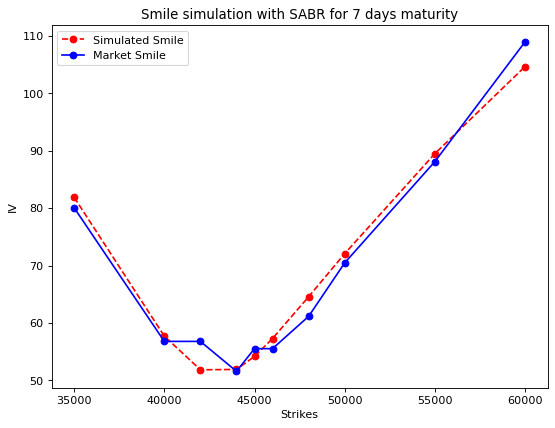

In [86]:
file_path = 'C:/Users/mbaud/Desktop/alternative finance/smile_btc_7d.png'

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(strikes,test_LN, "r--" ,  color='red',label='Simulated Smile', marker='o')
plt.plot(strikes,np.array(test_10.mark_iv), color='blue', label='Market Smile', marker='o')
plt.legend()
plt.title('Smile simulation with SABR for 7 days maturity')
plt.ylabel('IV')
plt.xlabel('Strikes')
plt.savefig(file_path)

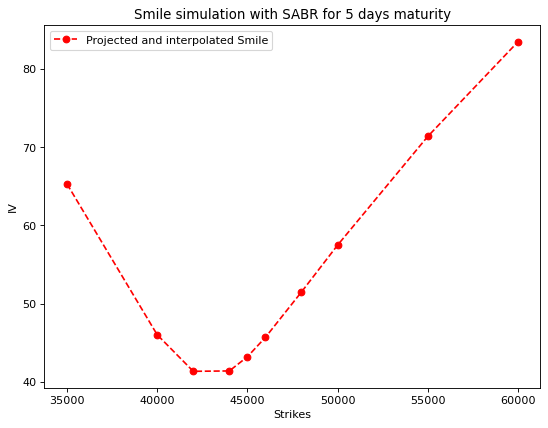

In [66]:
file_path = 'C:/Users/mbaud/Desktop/alternative finance/smile_proj.png'

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(strikes,test_LN,"r--", color='red', label='Projected and interpolated Smile', marker='o')
#plt.plot(strikes,np.array(test_10.mark_iv) , color='blue', label='Market Smile')
plt.legend()
plt.title('Smile simulation with SABR for 5 days maturity')
plt.ylabel('IV')
plt.xlabel('Strikes')
plt.savefig(file_path)

In [46]:
options=[]
vol_smile=[0.7976137394880913,0.6900328301671004,1.7719044833110584,1.456825157865576,0.49357838818973515,0.48521943402196066,0.6477234438039398,0.4658970570763057,0.6651604523055288,0.6456115211902828]
vol_fixed=[]
for vol in range(1,1+len(vol_smile)):
    options.append('Opt '+str(vol))
    vol_fixed.append(0.6442)

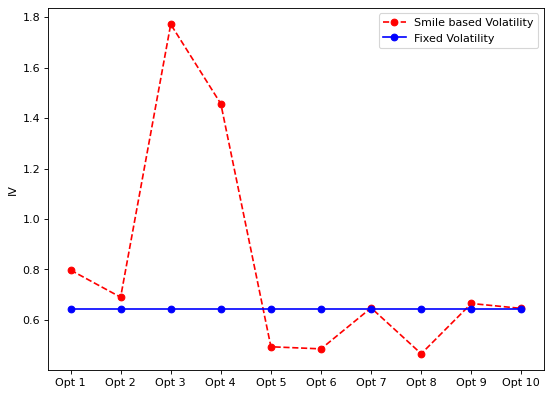

In [54]:
file_path = 'C:/Users/mbaud/Desktop/alternative finance/smile_fixed.png'

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(options,vol_smile,"r--", color='red' , marker='o',label= 'Smile based Volatility')
plt.plot(options,vol_fixed, color='blue', marker='o',label='Fixed Volatility')
plt.legend()
plt.ylabel('IV')
plt.savefig(file_path)

In [69]:
print(hagan2002LN.lognormal_vol(47000, f = spot, t = 5, alpha = calibration_LN[0],
                                             beta = beta,
                                             rho = calibration_LN[1], volvol = calibration_LN[2]))


0.48521907982455303


In [72]:
print(hagan2002LN.lognormal_vol(45000, f = spot, t = 5, alpha = calibration_LN[0],
                                             beta = beta,
                                             rho = calibration_LN[1], volvol = calibration_LN[2]))

0.4319962721384017


In [38]:
K_spot = 43503.85
K_90=0.9*K_spot

x1=(hagan2002LN.lognormal_vol(K_spot, f = spot, t = 1, alpha = calibration_LN[0],
                                             beta = beta,
                                             rho = calibration_LN[1], volvol = calibration_LN[2]) )

x2=(hagan2002LN.lognormal_vol(K_90, f = spot, t = 1, alpha = calibration_LN[0],
                                             beta = beta,
                                             rho = calibration_LN[1], volvol = calibration_LN[2]) )
print(x1,x2)
print(x2-x1)

0.6159521511803719 0.8739023796150985
0.2579502284347266


In [42]:
print(hagan2002LN.lognormal_vol(43999, f = spot, t = 3, alpha = calibration_LN[0],
                                             beta = beta,
                                             rho = calibration_LN[1], volvol = calibration_LN[2]) )


1.4567258287343017


In [12]:
from datetime import date

today = date.today()

# dd/mm/YY
d1 = today.strftime("%d/%m/%Y")
print("d1 =", d1)

d1 = 14/04/2022


In [ ]:
d1=str(d1)
date=d1[0]+d1[1]+'_'+d1[3]+d1[4]+'_'+d1[6]+d1[7]+d1[8]+d1[9]
date

In [ ]:
btc_df.to_csv(f'C:/Users/mbaud/Desktop/alternative finance/data deredit/derebit_data_{date}.csv', sep=';')